In [29]:
import warnings
import itertools

import pandas as pd
import numpy as np
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.forecasting.model_selection import (
    ForecastingRandomizedSearchCV,
    ExpandingWindowSplitter,
)
from sktime.utils.plotting import plot_series

from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.stream import UpdateEvery

from src.data import load_train_test
from src import get_config, plot_windows, get_rolling_predictions

### Preparación de los datos

In [30]:
config = get_config()
train, test = load_train_test(config.processed_data_path)
train.tail()

,90,102,101,107,65,103,missing,precipitation,festivos
timestamps,,,,,,,,,
2022-11-14 19:00:00,5.0,2.0,5.0,6.0,5.0,14.0,0,0.0,0
2022-11-14 20:00:00,10.0,2.0,4.0,6.0,6.0,13.0,0,0.0,0
2022-11-14 21:00:00,7.0,12.0,4.0,5.0,4.0,9.0,0,0.0,0
2022-11-14 22:00:00,9.0,7.0,4.0,5.0,7.0,12.0,0,0.0,0
2022-11-14 23:00:00,8.0,7.0,4.0,5.0,7.0,10.0,0,0.0,0


In [31]:
def shift_columns(dataframe, columns, k):
    for column in columns:
        new_column_name = f"{column}_hace_{k}_horas"
        dataframe[new_column_name] = dataframe[column].shift(k)
    return dataframe


exo_stations = ["102", "101", "107", "65", "103"]
train = shift_columns(train, exo_stations, 1)
test = shift_columns(test, exo_stations, 1)
# Fix test first row
test.iloc[0, 9:] = train.iloc[-1, 1:6].values
test.head()

,90,102,101,107,65,103,missing,precipitation,festivos,102_hace_1_horas,101_hace_1_horas,107_hace_1_horas,65_hace_1_horas,103_hace_1_horas
timestamps,,,,,,,,,,,,,,
2022-11-15 00:00:00,5.0,7.0,3.0,4.0,6.0,10.0,0,0.0,0,7.0,4.0,5.0,7.0,10.0
2022-11-15 01:00:00,4.0,7.0,3.0,4.0,7.0,9.0,0,0.0,0,7.0,3.0,4.0,6.0,10.0
2022-11-15 02:00:00,5.0,7.0,3.0,2.0,8.0,8.0,0,0.0,0,7.0,3.0,4.0,7.0,9.0
2022-11-15 03:00:00,5.0,6.0,3.0,3.0,8.0,8.0,0,0.0,0,7.0,3.0,2.0,8.0,8.0
2022-11-15 04:00:00,5.0,6.0,3.0,3.0,8.0,8.0,0,0.1,0,6.0,3.0,3.0,8.0,8.0


In [32]:
# Add lagged target a week ago
train = shift_columns(train, [str(config.target_station_id)], 24 * 7)
test = shift_columns(test, [str(config.target_station_id)], 24 * 7)

# Fix test 24*7 first rows
test.iloc[: 24 * 7, -1] = train.iloc[-24 * 7 :, 0].values
test.head()

,90,102,101,107,65,103,missing,precipitation,festivos,102_hace_1_horas,101_hace_1_horas,107_hace_1_horas,65_hace_1_horas,103_hace_1_horas,90_hace_168_horas
timestamps,,,,,,,,,,,,,,,
2022-11-15 00:00:00,5.0,7.0,3.0,4.0,6.0,10.0,0,0.0,0,7.0,4.0,5.0,7.0,10.0,6.0
2022-11-15 01:00:00,4.0,7.0,3.0,4.0,7.0,9.0,0,0.0,0,7.0,3.0,4.0,6.0,10.0,5.0
2022-11-15 02:00:00,5.0,7.0,3.0,2.0,8.0,8.0,0,0.0,0,7.0,3.0,4.0,7.0,9.0,4.0
2022-11-15 03:00:00,5.0,6.0,3.0,3.0,8.0,8.0,0,0.0,0,7.0,3.0,2.0,8.0,8.0,6.0
2022-11-15 04:00:00,5.0,6.0,3.0,3.0,8.0,8.0,0,0.1,0,6.0,3.0,3.0,8.0,8.0,6.0


In [33]:
# Drop exo_stations
train = train.drop(columns=exo_stations)
test = test.drop(columns=exo_stations)

### Definición del modelo

In [34]:
# Filter train data to use oly data since september 2022
train = train[train.index >= "2022-09-01"]

target_column = str(config.target_station_id)
train_target_series = train[target_column]
X_train = train.drop(columns=[target_column])
test_target_series = test[target_column]
X_test = test.drop(columns=[target_column])

In [35]:
X_test.head()

,missing,precipitation,festivos,102_hace_1_horas,101_hace_1_horas,107_hace_1_horas,65_hace_1_horas,103_hace_1_horas,90_hace_168_horas
timestamps,,,,,,,,,
2022-11-15 00:00:00,0,0.0,0,7.0,4.0,5.0,7.0,10.0,6.0
2022-11-15 01:00:00,0,0.0,0,7.0,3.0,4.0,6.0,10.0,5.0
2022-11-15 02:00:00,0,0.0,0,7.0,3.0,4.0,7.0,9.0,4.0
2022-11-15 03:00:00,0,0.0,0,7.0,3.0,2.0,8.0,8.0,6.0
2022-11-15 04:00:00,0,0.1,0,6.0,3.0,3.0,8.0,8.0,6.0


In [43]:
random_forest = make_reduction(
    RandomForestRegressor(n_estimators=200, random_state=42),
    window_length=2,
    strategy="recursive",
)

In [37]:
random_forest.fit(train_target_series, X=X_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(n_estimators=200, random_state=42),
                                     window_length=2)

In [44]:
model = UpdateEvery(random_forest, update_interval=24)
model.fit(train_target_series, X=X_train)

UpdateEvery(forecaster=RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(n_estimators=200, random_state=42),
                                                            window_length=2),
            update_interval=24)

In [45]:
predictions = model.update_predict(
    test_target_series,
    X=X_test,
    update_params=False,
)
predictions

2022-11-15 01:00:00    5.210000
2022-11-15 02:00:00    3.982500
2022-11-15 03:00:00    4.837500
2022-11-15 04:00:00    4.425000
2022-11-15 05:00:00    4.430000
                         ...   
2022-12-31 19:00:00    9.660417
2022-12-31 20:00:00    8.981667
2022-12-31 21:00:00    4.685000
2022-12-31 22:00:00    4.432500
2022-12-31 23:00:00    4.815000
Name: 90, Length: 1127, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ocupación'>)

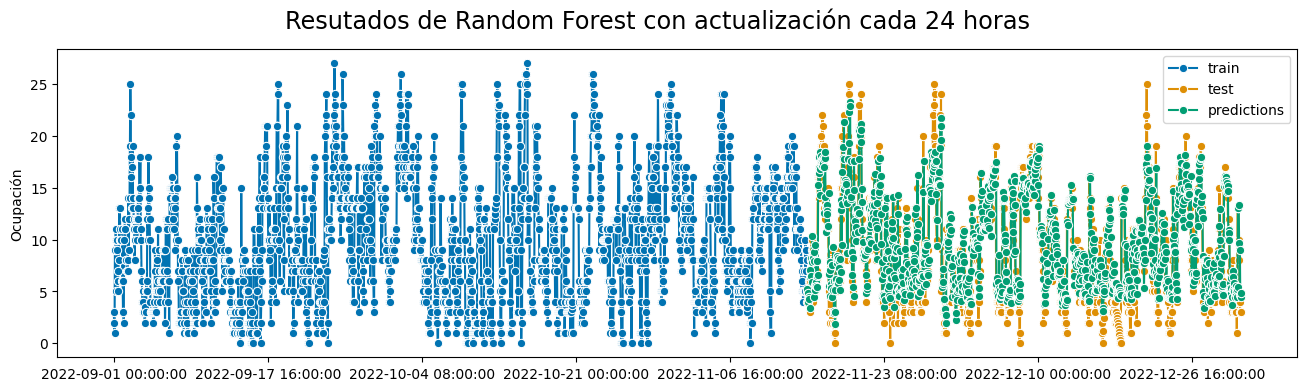

In [46]:
#title = f"Resutados de SARIMAX({best_params['order']}, {best_params['seasonal_order']}) con actualización cada 24 horas"
title = f"Resutados de Random Forest con actualización cada 24 horas"
plot_series(
    train_target_series,
    test_target_series,
    predictions,
    labels=["train", "test", "predictions"],
    title=title,
    y_label="Ocupación",
)

In [47]:
mean_squared_error(test_target_series[:-1], predictions)

1.8983427009715848

In [48]:
from sktime.forecasting.sarimax import SARIMAX

In [ ]:
order = (1, 0, 15)
seasonal_order = (1, 0, 1, 24)
sarimax = SARIMAX(
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
    exog=X_train,
)
model = UpdateEvery(sarimax, update_interval=24)
model.fit(train_target_series)

In [52]:
predictions = model.predict(fh=test_target_series.index, X=X_test)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ocupación'>)

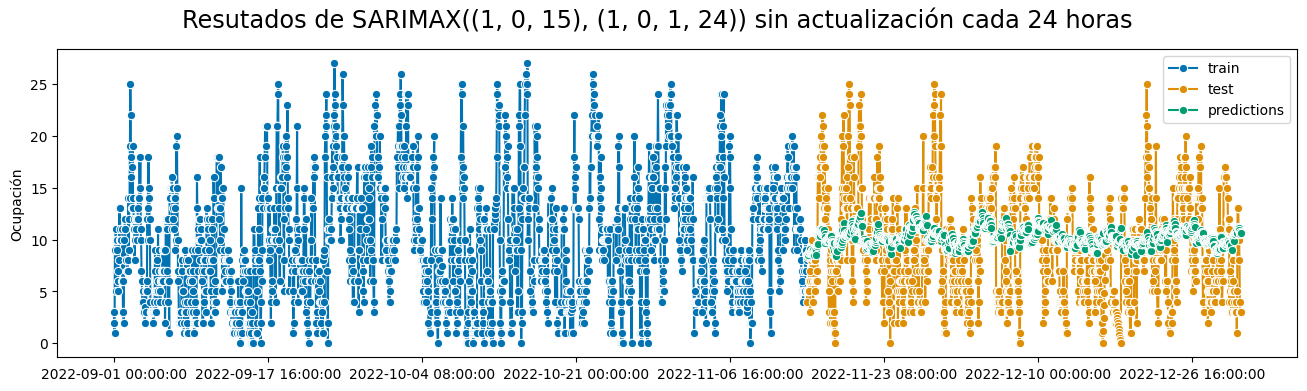

In [54]:
title = f"Resutados de SARIMAX({order}, {seasonal_order}) sin actualización cada 24 horas"
plot_series(
    train_target_series,
    test_target_series,
    predictions,
    labels=["train", "test", "predictions"],
    title=title,
    y_label="Ocupación",
)

In [56]:
mean_squared_error(test_target_series, predictions)

24.885603527159176